# **Построение социального графа**

В данной работе мы построим социальный граф для пользователей одного узла в платформе Mastodon. Cтоит отметить, что граф будет строиться только для пользователей зарегистрированных в главном узле, остальные пользователи не будут добавляться в граф. Ниже мы устанавливаем библиотеку **Mastodon.py** которая поможет удобно получить данные о пользователях. 

In [1]:
!pip install Mastodon.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 KB 4.5 MB/s eta 0:00:00


Чтобы пользоваться данным API нужно будет зарегистрироваться на выбранном сервере и также после этого создать приложение использовав код ниже (приложение нужно создавать один раз для сервера). Также важно сохранить файл который указан в переменной to_file так как в нем будет храниться специальный ключ. 

In [3]:
from mastodon import Mastodon

app_name = 'social_graph'

'''
Mastodon.create_app(
    app_name,
    api_base_url = 'https://horrorhub.club/',
    to_file = 'token1.txt'
)
'''


"\nMastodon.create_app(\n    app_name,\n    api_base_url = 'https://horrorhub.club/',\n    to_file = 'token1.txt'\n)\n"

Далее запускаем функцию login и первым аргументом передаем путь к выше созданному файлу (содержащему токен), а вторым аргументом дополнительный файл который содержит личные данные (первая строчка почта, вторая пароль, третья файл в который сохранится дополнительная необходимая информация). 

In [4]:
def login(client_id_path, personal_data_path):
  mastodon = Mastodon(client_id=client_id_path, )

  f = open(personal_data_path, "r")
  mail = f.readline()
  mail = mail.replace('\n', '')

  password = f.readline()
  password = password.replace('\n', '')

  to_file = f.readline()
  to_file = to_file.replace('\n', '')
  f.close()

  mastodon.log_in(
      mail,
      password,
      to_file=to_file
  )

  return mastodon

mastodon = login('tokens.txt', 'psd.txt')



Теперь прописываем функции get_followers и get_following, которые возвращают списки никнеймов подписчиков и подписок для указанного пользователя. Данные списки могут содержать людей из других серверов, узнать их можно по псевдониму так как они содержат в имени название своего сервера. Поэтому добавляем дополнительную функцию find_main_domains, которая оставляет никнеймы людей с главного сервера и возвращает новый список. 

In [5]:
def get_followers(self, acct):
    user_id = Mastodon.account_lookup(self=self, acct=acct)['id']
    followers = Mastodon.account_followers(self=mastodon, id=user_id)
    names = []

    for follower in followers:
        names.append(follower['acct'])

    return names


def get_following(self, acct):
    user_id = Mastodon.account_lookup(self=self, acct=acct)['id']
    followers = Mastodon.account_following(self=mastodon, id=user_id)
    names = []

    for follower in followers:
        names.append(follower['acct'])

    return names


def find_main_domains(followers):
    new_list = []
    for follower in followers:
        if not ('@' in follower):
            new_list.append(follower)

    return new_list

Далее используя алгоритма обхода графа (Depth-First Search), мы пишем функцию get_graphs которая заполняет два словаря. Первый followers_graph, где ключ имя, а значение список подписчиков. Второй словарь following_graph вместо списка подписчиков, содержит список подписок. 

In [17]:
followers_graph = {}
following_graph = {}

def get_graphs(user_name):
    if user_name in followers_graph.keys() and user_name in following_graph.keys():
        return

    # followers
    user_followers = get_followers(self=mastodon, acct=user_name)
    user_followers = find_main_domains(user_followers)
    followers_graph[user_name] = user_followers

    # following
    user_following = get_following(self=mastodon, acct=user_name)
    user_following = find_main_domains(user_following)
    following_graph[user_name] = user_following

    for follower in user_followers:
      if follower in followers_graph.keys():
        continue

      get_graphs(follower)

    for following in user_following:
      if following in following_graph.keys():
        continue

      get_graphs(following)


get_graphs('periplum')
print(followers_graph)

{'periplum': ['SerKloch', 'kotofey', 'virtur', 'Groot33', 'set', 'altimon', 'zif', 'sdatsenko', 'Bambi', 'sia', 'owl'], 'SerKloch': ['nitro', 'Rick', 'irynfedy2017do', 'set', 'Antoniv', 'NichkaNightUA'], 'nitro': ['SerKloch', 'NichkaNightUA'], 'NichkaNightUA': ['nitro', 'SerKloch', 'Igor', 'kotofey', 'Svitlana', 'Zapadenka', 'valovenil', 'just_sun'], 'Igor': ['nitro', 'Antoniv', 'Rick', 'kotofey', 'Elen_Astra', 'valovenil', 'NichkaNightUA'], 'Antoniv': ['nitro', 'SerKloch', 'periplum', 'Igor', 'kotofey', 'Svitlana', 'Gary', 'valovenil', 'Rick'], 'kotofey': ['Elen_Astra', 'Zapadenka', 'Rick', 'NichkaNightUA', 'Antoniv'], 'Elen_Astra': ['kotofey', 'Igor', 'valovenil', 'just_sun', 'Rick', 'Antoniv', 'NichkaNightUA'], 'valovenil': ['kotofey', 'Igor', 'Elen_Astra', 'Antoniv', 'Rick', 'NichkaNightUA'], 'Rick': ['nitro', 'kotofey', 'Igor', 'valovenil', 'Elen_Astra', 'Antoniv', 'NichkaNightUA'], 'just_sun': ['kotofey', 'Elen_Astra', 'NichkaNightUA'], 'Zapadenka': ['kotofey', 'NichkaNightUA'], 

Теперь мы заполняем матрицу, которая является первой репрезентацией нашего графа. 

In [8]:
import numpy as np

all_users = list(followers_graph.keys())
N = len(all_users)

arr = np.zeros((N,N))

for i in range(N):
  user1 = all_users[i]
  for j in range(N):
    user2 = all_users[j]
    user2_subs = followers_graph[user2]

    # if user1 subscribes to user2
    if user1 in user2_subs:
      arr[i][j] += 1


for i in range(N):
  user1 = all_users[i]
  for j in range(N):
    user2 = all_users[j]
    user2_subs = following_graph[user2]

    # if user1 subscribes to user2
    if user1 in user2_subs:
      arr[i][j] += 1


Чтобы наглядно показать ее используем модуль pyplot. (Черный цвет на пересечении означает, что никто не подписан, зеленый, что кто-то один подписан и желтый означает взаимную подписку. 

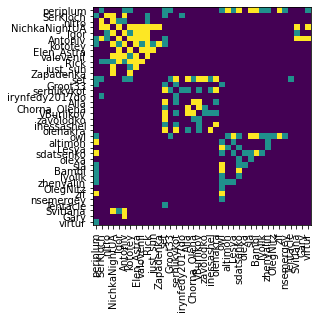

In [19]:
import matplotlib.pyplot as plt

plt.imshow(arr)
plt.yticks(range(N), all_users)
plt.xticks(range(N), all_users, rotation=90)
plt.show()

Для того чтобы построить обычный вид графа, нужно использовать дополнительные библиотеки. Однако для удобства сначала мы соберем данные в таблицу pandas. Также люди со взаимной подпиской (weight=2) буду иметь красный цвет связи, а односторонней подпиской (weight=1) синий цвет.

> Блок с отступами



In [20]:
import pandas as pd


dict = {'Source': ['test'],
                   'Target': ['test'],
                   'weight': [0],
        'color': ['red']}
df = pd.DataFrame(dict)

some_set = []
for i in range(N):
  user1 = all_users[i]
  some_set.append(user1)

  for j in range(N):
    user2 = all_users[j]

    if user2 in some_set:
      continue

    weight = arr[i][j]
    color = None
    if weight == 2:
      color = 'red'
    else:
      color = 'blue'

    if weight > 0:
      df.loc[len(df.index)] = [user1, user2, weight, color]

df = df.drop(0)
df

,Source,Target,weight,color
1,periplum,SerKloch,1.0,blue
2,periplum,Antoniv,1.0,blue
3,periplum,kotofey,1.0,blue
4,periplum,set,1.0,blue
5,periplum,Groot33,1.0,blue
...,...,...,...,...
99,sdatsenko,olexa,1.0,blue
100,sdatsenko,sia,1.0,blue
101,sdatsenko,Bambi,2.0,red
102,sdatsenko,lyolik,1.0,blue


Теперь с помощью networkx строим простой граф

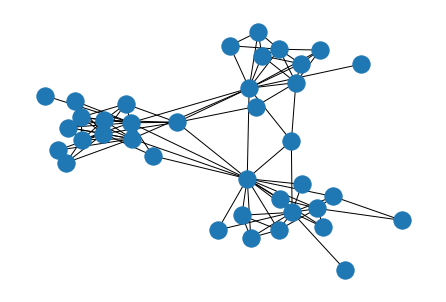

In [18]:
import networkx as nx

G = nx.from_pandas_edgelist(df, source='Source', target='Target', edge_attr=['weight', 'color'] )
nx.draw(G)

Однако чтобы построить более детальный и даже анимированный граф, устанавливаем библиотеку pyvis.


In [13]:
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 KB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.7 MB/s eta 0:00:00


После выполнения кода ниже, скачивается html файл. Открываем его и смотрим на результат. 

In [14]:
from pyvis.network import Network

net = Network(notebook=True)

net.from_nx(G)
net.show('graph1.html')

graph1.html
